In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
%matplotlib inline
import keras
from keras.layers import Dense, Dropout, Input, BatchNormalization, Reshape, Conv2D, UpSampling2D, Activation, Flatten
from keras.models import Model, Sequential
from keras.datasets import mnist
from keras.initializers import RandomNormal
from tqdm import tqdm
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
from keras import backend as K

K.set_image_dim_ordering('th')

np.random.seed(1000)

In [140]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [141]:
path = 'drive/My Drive/Colab Notebooks/GAN/'

print(os.listdir(path))

['Loss', 'Models', 'GenImages']


In [142]:
def load_data():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = (x_train.astype(np.float32) - 127.5)/127.5
    
    # convert shape of x_train from (60000, 28, 28) to (60000, 784) 
    # 784 columns per row
    #x_train = x_train.reshape(60000, 784)
    x_train = x_train[:, np.newaxis, :, :]
    return (x_train, y_train, x_test, y_test)


(X_train, y_train,X_test, y_test)=load_data()
print(X_train.shape)

(60000, 1, 28, 28)


In [0]:
def adam_optimizer():
    return Adam(lr=0.0002, beta_1=0.5)

In [144]:
def create_generator():
    generator = Sequential()
    
    generator.add(Dense(128*7*7, input_dim=100, kernel_initializer=RandomNormal(stddev=0.02)))
    generator.add(LeakyReLU(0.2))
    generator.add(Reshape((128, 7, 7)))
    generator.add(UpSampling2D(size=(2, 2), data_format = 'channels_first'))
    
    generator.add(Conv2D(64, kernel_size=(5, 5), padding='same' ,data_format = 'channels_first'))
    generator.add(LeakyReLU(0.2))
    generator.add(UpSampling2D(size=(2, 2), data_format = 'channels_first'))
    
    generator.add(Conv2D(1, kernel_size=(5, 5), padding='same', activation='tanh', data_format = 'channels_first'))
    generator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
    
    return generator


generator=create_generator()
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 6272)              633472    
_________________________________________________________________
leaky_re_lu_25 (LeakyReLU)   (None, 6272)              0         
_________________________________________________________________
reshape_7 (Reshape)          (None, 128, 7, 7)         0         
_________________________________________________________________
up_sampling2d_13 (UpSampling (None, 128, 14, 14)       0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 64, 14, 14)        204864    
_________________________________________________________________
leaky_re_lu_26 (LeakyReLU)   (None, 64, 14, 14)        0         
_________________________________________________________________
up_sampling2d_14 (UpSampling (None, 64, 28, 28)        0         
__________

In [145]:
def create_discriminator():
    discriminator = Sequential()
    
    discriminator.add(Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding='same', input_shape=(1, 28, 28), kernel_initializer=RandomNormal(stddev=0.02),
                            data_format = 'channels_first'))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
    
    discriminator.add(Conv2D(128, kernel_size=(5, 5), strides=(2, 2), padding='same', data_format = 'channels_first'))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
    
    discriminator.add(Flatten())
    discriminator.add(Dense(1, activation='sigmoid'))
    discriminator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
    
    return discriminator

discriminator = create_discriminator()
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 64, 14, 14)        1664      
_________________________________________________________________
leaky_re_lu_27 (LeakyReLU)   (None, 64, 14, 14)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 64, 14, 14)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 128, 7, 7)         204928    
_________________________________________________________________
leaky_re_lu_28 (LeakyReLU)   (None, 128, 7, 7)         0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 128, 7, 7)         0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 6272)              0         
__________

In [146]:
def create_gan(discriminator, generator):
    discriminator.trainable=False
    gan_input = Input(shape=(100,))
    x = generator(gan_input)
    gan_output= discriminator(x)
    gan= Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer='adam')
    return gan

gan = create_gan(discriminator, generator)
gan.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_13 (Sequential)   (None, 1, 28, 28)         839937    
_________________________________________________________________
sequential_14 (Sequential)   (None, 1)                 212865    
Total params: 1,052,802
Trainable params: 839,937
Non-trainable params: 212,865
_________________________________________________________________


In [0]:
dLosses = []
gLosses = []

In [0]:
def plotLoss(epoch):
    plt.figure(figsize=(10, 8))
    plt.plot(dLosses, label='Discriminitive loss')
    plt.plot(gLosses, label='Generative loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(path + 'Loss/dcgan_loss_epoch_%d.png' % epoch)

In [0]:
def plotGeneratedImages(epoch, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, 100])
    generatedImages = generator.predict(noise)

    plt.figure(figsize=figsize)
    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generatedImages[i, 0], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig(path + 'GenImages/dcgan_generated_image_epoch_%d.png' % epoch)

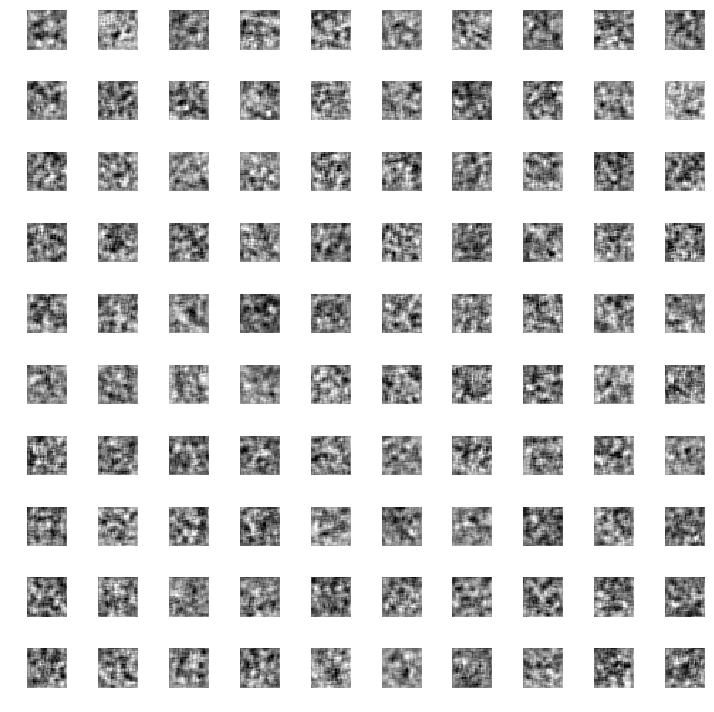

In [150]:
plotGeneratedImages(0, examples=100, dim=(10, 10), figsize=(10, 10))

In [0]:
def saveModels(epoch):
    generator.save(path + 'Models/dcgan_generator_epoch_%d.h5' % epoch)
    discriminator.save(path + 'Models/dcgan_discriminator_epoch_%d.h5' % epoch)

  0%|          | 0/468 [00:00<?, ?it/s]

Epochs: 60
Batch size: 128
Batches per epoch: 468.75
--------------- Epoch 1 ---------------


  0%|          | 2/468 [00:00<00:43, 10.77it/s]

--------------- Epoch 2 ---------------


  0%|          | 2/468 [00:00<00:33, 13.91it/s]

--------------- Epoch 3 ---------------


  0%|          | 2/468 [00:00<00:44, 10.49it/s]

--------------- Epoch 4 ---------------


  0%|          | 2/468 [00:00<00:32, 14.37it/s]

--------------- Epoch 5 ---------------


  0%|          | 2/468 [00:00<00:41, 11.27it/s]

--------------- Epoch 6 ---------------


  0%|          | 2/468 [00:00<00:31, 14.59it/s]

--------------- Epoch 7 ---------------


  0%|          | 2/468 [00:00<00:32, 14.38it/s]

--------------- Epoch 8 ---------------


  0%|          | 2/468 [00:00<00:38, 12.01it/s]

--------------- Epoch 9 ---------------


  0%|          | 2/468 [00:00<00:33, 13.99it/s]

--------------- Epoch 10 ---------------


  0%|          | 2/468 [00:00<00:32, 14.53it/s]

--------------- Epoch 11 ---------------


  0%|          | 2/468 [00:00<00:31, 14.67it/s]

--------------- Epoch 12 ---------------


  0%|          | 2/468 [00:00<00:32, 14.26it/s]

--------------- Epoch 13 ---------------


  0%|          | 2/468 [00:00<00:32, 14.29it/s]

--------------- Epoch 14 ---------------


  0%|          | 2/468 [00:00<00:31, 14.67it/s]

--------------- Epoch 15 ---------------


  0%|          | 2/468 [00:00<00:42, 10.88it/s]

--------------- Epoch 16 ---------------


  0%|          | 2/468 [00:00<00:32, 14.27it/s]

--------------- Epoch 17 ---------------


  0%|          | 2/468 [00:00<00:31, 14.77it/s]

--------------- Epoch 18 ---------------


  0%|          | 2/468 [00:00<00:32, 14.54it/s]

--------------- Epoch 19 ---------------


  0%|          | 2/468 [00:00<00:33, 13.77it/s]

--------------- Epoch 20 ---------------


  0%|          | 2/468 [00:00<00:32, 14.49it/s]

--------------- Epoch 21 ---------------


  0%|          | 2/468 [00:00<00:33, 14.07it/s]

--------------- Epoch 22 ---------------


  0%|          | 2/468 [00:00<00:32, 14.32it/s]

--------------- Epoch 23 ---------------


  0%|          | 2/468 [00:00<00:32, 14.42it/s]

--------------- Epoch 24 ---------------


  0%|          | 2/468 [00:00<00:31, 14.62it/s]

--------------- Epoch 25 ---------------


  0%|          | 2/468 [00:00<00:32, 14.22it/s]

--------------- Epoch 26 ---------------


  0%|          | 2/468 [00:00<00:32, 14.43it/s]

--------------- Epoch 27 ---------------


  0%|          | 2/468 [00:00<00:32, 14.23it/s]

--------------- Epoch 28 ---------------


  0%|          | 2/468 [00:00<00:32, 14.37it/s]

--------------- Epoch 29 ---------------


  0%|          | 2/468 [00:00<00:32, 14.54it/s]

--------------- Epoch 30 ---------------


  0%|          | 2/468 [00:00<00:38, 12.10it/s]

--------------- Epoch 31 ---------------


  0%|          | 2/468 [00:00<00:31, 14.78it/s]

--------------- Epoch 32 ---------------


  0%|          | 2/468 [00:00<00:32, 14.51it/s]

--------------- Epoch 33 ---------------


  0%|          | 2/468 [00:00<00:31, 14.69it/s]

--------------- Epoch 34 ---------------


  0%|          | 2/468 [00:00<00:32, 14.50it/s]

--------------- Epoch 35 ---------------


  0%|          | 2/468 [00:00<00:32, 14.42it/s]

--------------- Epoch 36 ---------------


  0%|          | 2/468 [00:00<00:32, 14.48it/s]

--------------- Epoch 37 ---------------


  0%|          | 2/468 [00:00<00:31, 14.63it/s]

--------------- Epoch 38 ---------------


  0%|          | 2/468 [00:00<00:33, 13.94it/s]

--------------- Epoch 39 ---------------


  0%|          | 2/468 [00:00<00:31, 14.58it/s]

--------------- Epoch 40 ---------------


  0%|          | 1/468 [00:00<00:49,  9.39it/s]

--------------- Epoch 41 ---------------


  0%|          | 2/468 [00:00<00:33, 13.98it/s]

--------------- Epoch 42 ---------------


  0%|          | 2/468 [00:00<00:32, 14.45it/s]

--------------- Epoch 43 ---------------


  0%|          | 2/468 [00:00<00:32, 14.37it/s]

--------------- Epoch 44 ---------------


  0%|          | 2/468 [00:00<00:32, 14.16it/s]

--------------- Epoch 45 ---------------


  0%|          | 2/468 [00:00<00:32, 14.43it/s]

--------------- Epoch 46 ---------------


  0%|          | 2/468 [00:00<00:32, 14.35it/s]

--------------- Epoch 47 ---------------


  0%|          | 2/468 [00:00<00:31, 14.62it/s]

--------------- Epoch 48 ---------------


  0%|          | 2/468 [00:00<00:32, 14.40it/s]

--------------- Epoch 49 ---------------


  0%|          | 2/468 [00:00<00:32, 14.54it/s]

--------------- Epoch 50 ---------------


  0%|          | 2/468 [00:00<00:44, 10.59it/s]

--------------- Epoch 51 ---------------


  0%|          | 2/468 [00:00<00:32, 14.50it/s]

--------------- Epoch 52 ---------------


  0%|          | 2/468 [00:00<00:32, 14.38it/s]

--------------- Epoch 53 ---------------


  0%|          | 2/468 [00:00<00:32, 14.16it/s]

--------------- Epoch 54 ---------------


  0%|          | 2/468 [00:00<00:33, 14.01it/s]

--------------- Epoch 55 ---------------


  0%|          | 2/468 [00:00<00:32, 14.42it/s]

--------------- Epoch 56 ---------------


  0%|          | 2/468 [00:00<00:32, 14.36it/s]

--------------- Epoch 57 ---------------


  0%|          | 2/468 [00:00<00:33, 13.84it/s]

--------------- Epoch 58 ---------------


  0%|          | 2/468 [00:00<00:33, 14.08it/s]

--------------- Epoch 59 ---------------


  0%|          | 2/468 [00:00<00:31, 14.68it/s]

--------------- Epoch 60 ---------------


100%|██████████| 468/468 [00:32<00:00, 14.30it/s]


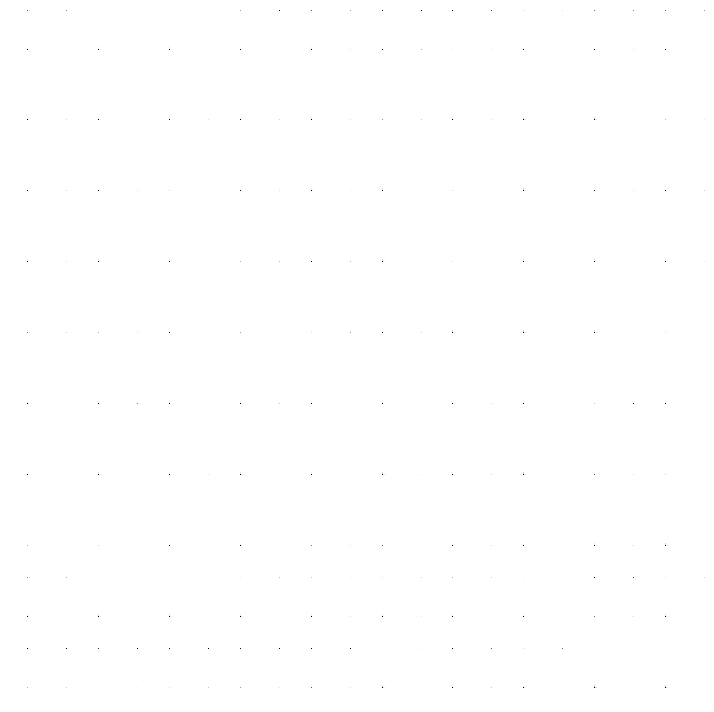

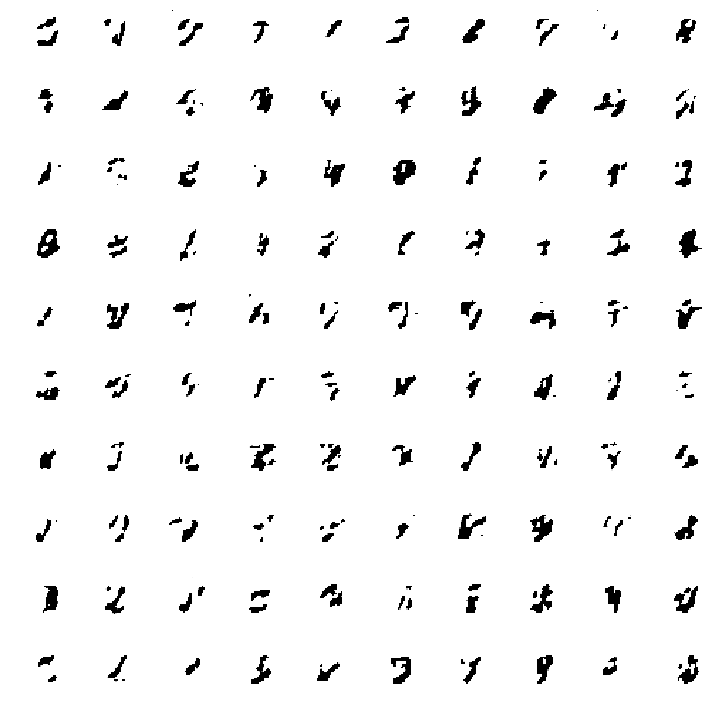

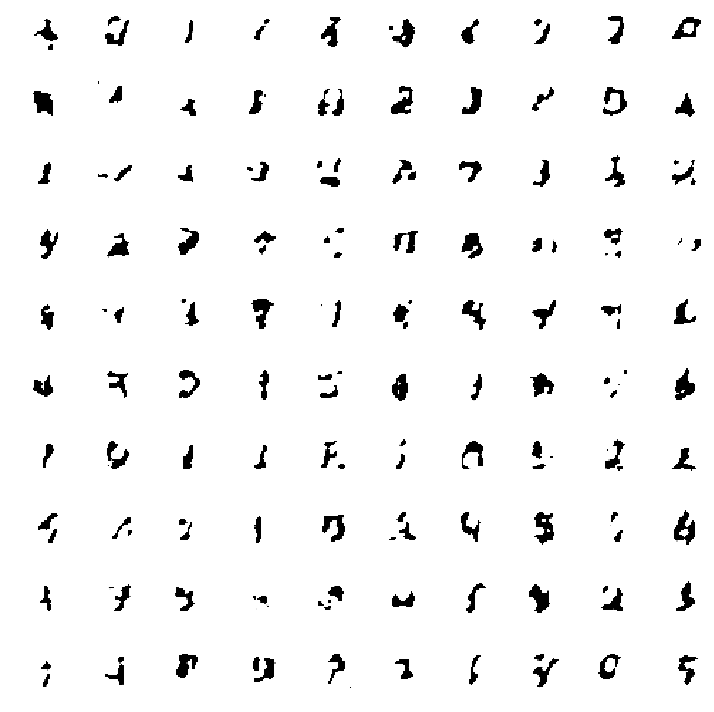

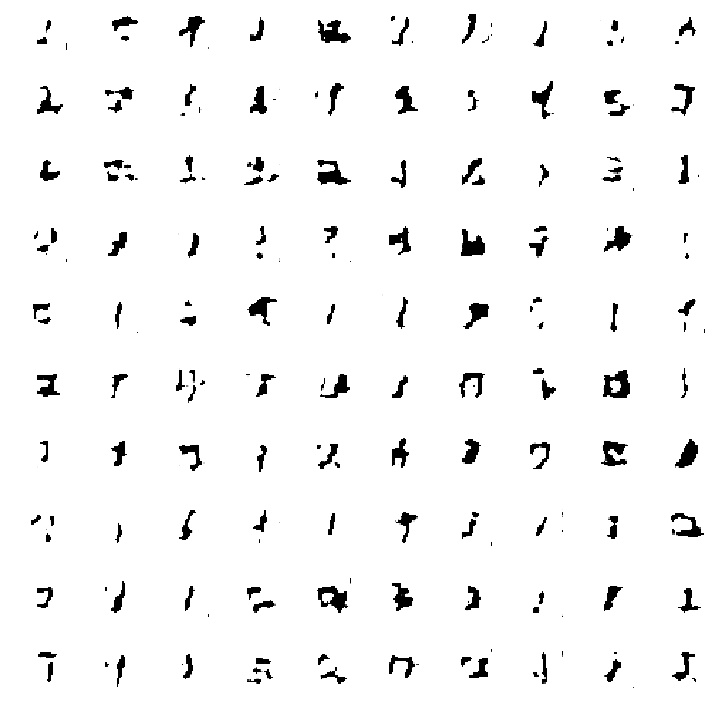

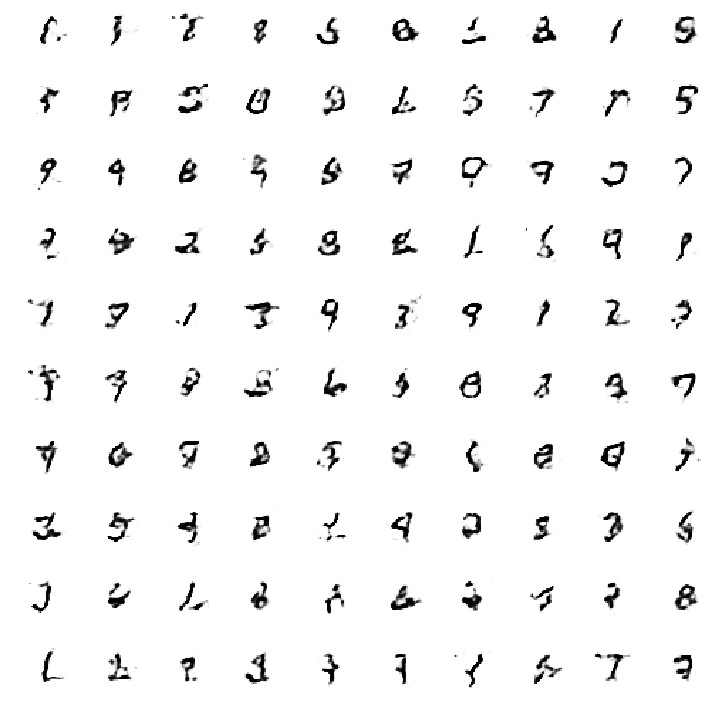

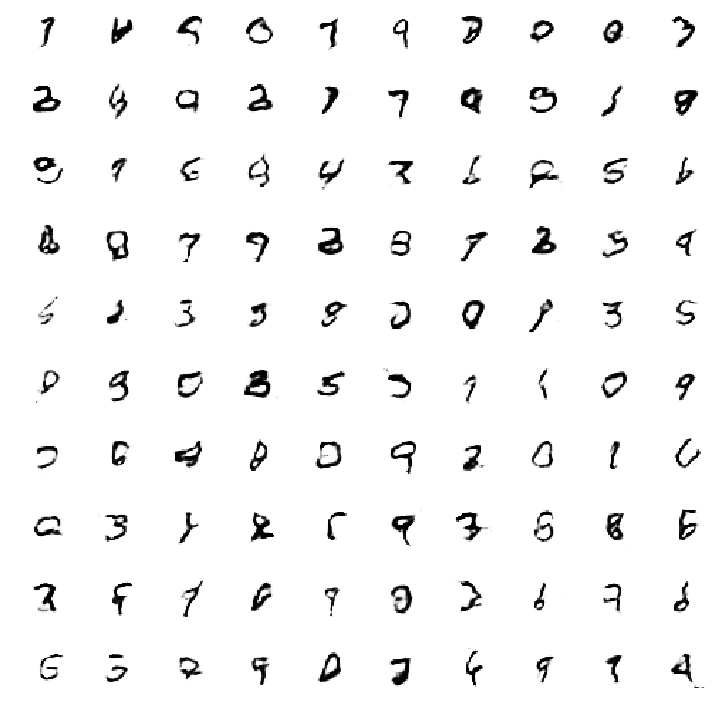

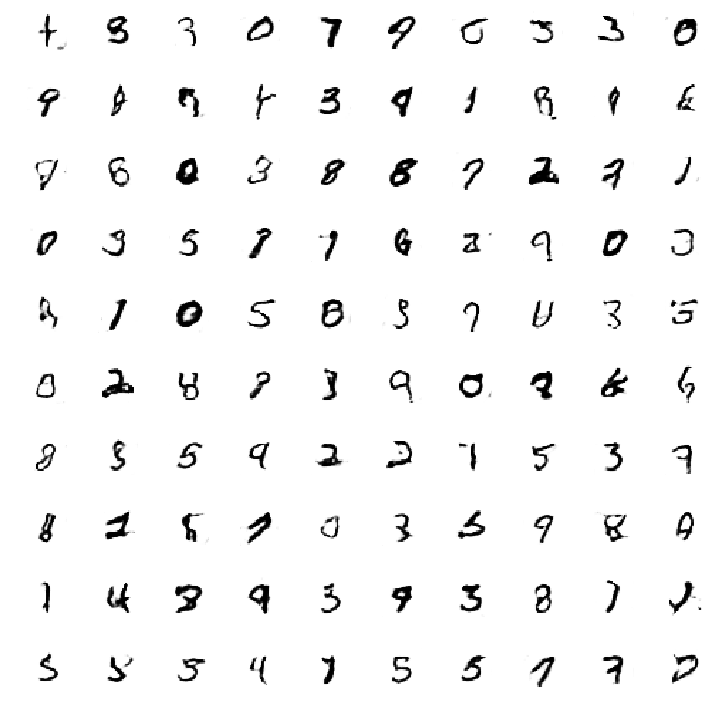

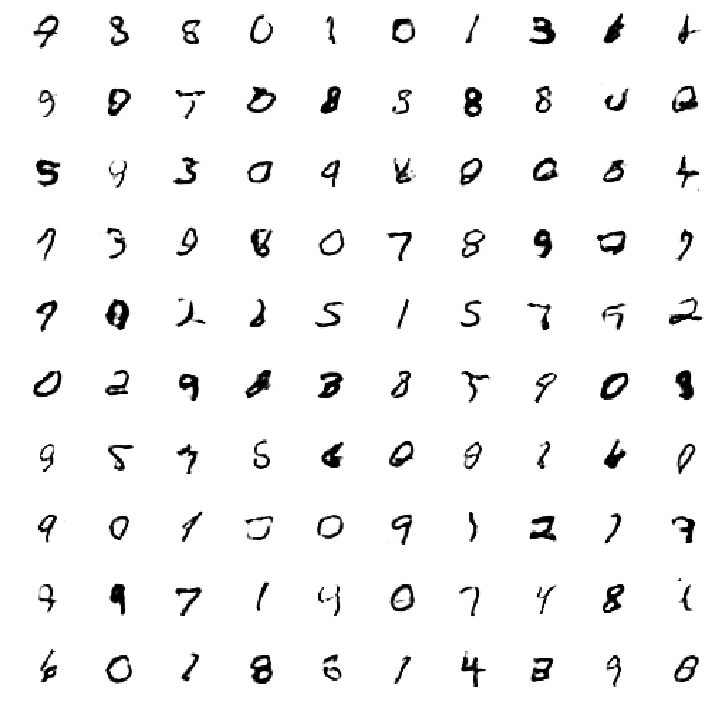

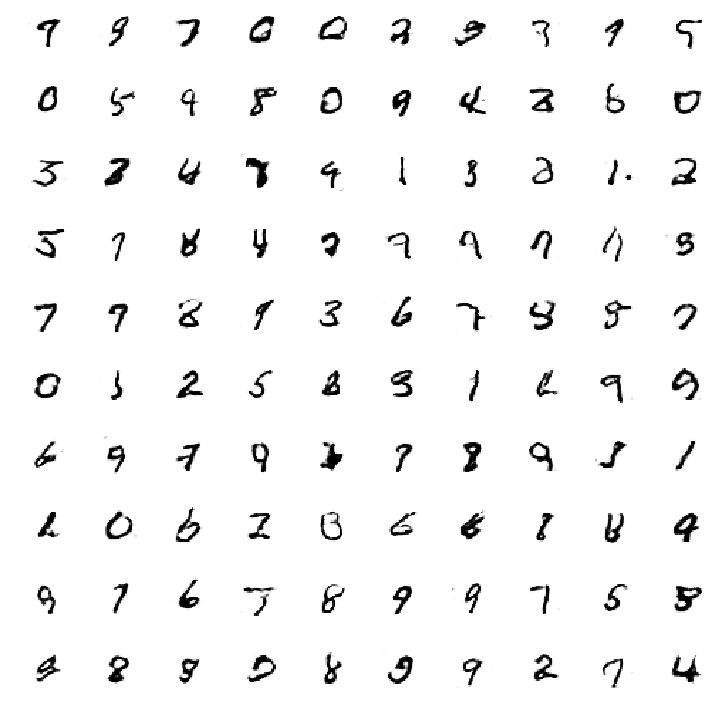

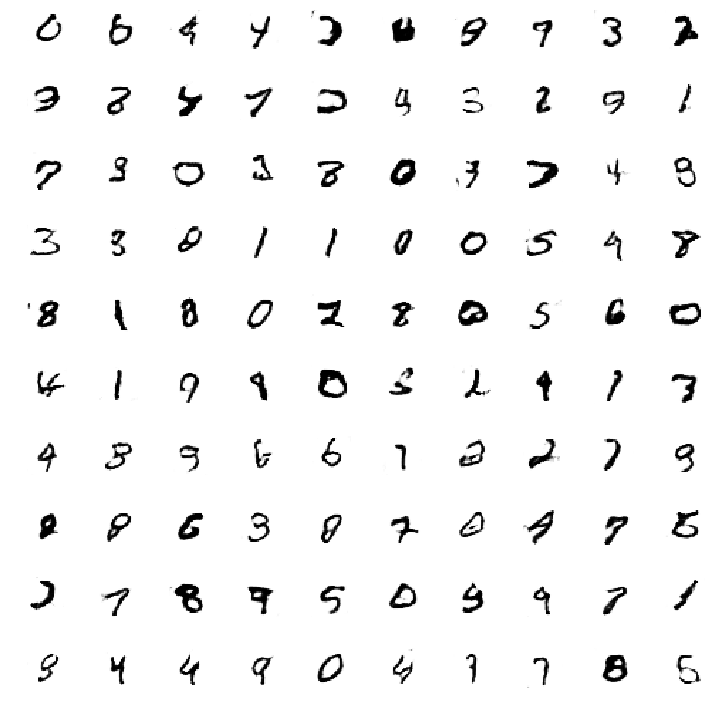

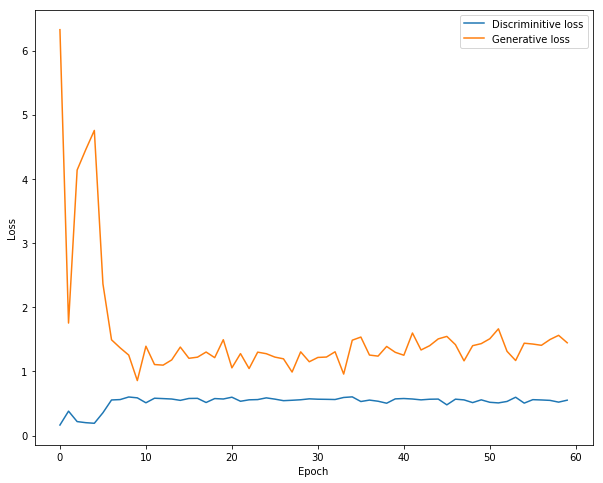

In [152]:
def training(epochs=1, batchSize=128):
    printer = [1, 2, 3, 5, 8, 15, 30, 40, 50, 60]
    batchCount = X_train.shape[0] / batchSize
    print (f'Epochs: {epochs}')
    print (f'Batch size: {batchSize}')
    print (f'Batches per epoch: {batchCount}')

    for e in range(1, epochs+1):
        print ('-'*15, 'Epoch %d' % e, '-'*15)
        for a in tqdm(range(int(batchCount))):
            # Get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batchSize, 100])
            imageBatch = X_train[np.random.randint(0, X_train.shape[0], size=batchSize)]

            # Generate fake MNIST images
            generatedImages = generator.predict(noise)
            X = np.concatenate([imageBatch, generatedImages])

            # Labels for generated and real data
            yDis = np.zeros(2*batchSize)
            # One-sided label smoothing
            yDis[:batchSize] = 0.9

            # Train discriminator
            discriminator.trainable = True
            dloss = discriminator.train_on_batch(X, yDis)

            # Train generator
            noise = np.random.normal(0, 1, size=[batchSize, 100])
            yGen = np.ones(batchSize)
            discriminator.trainable = False
            gloss = gan.train_on_batch(noise, yGen)

        # Store loss of most recent batch from this epoch
        dLosses.append(dloss)
        gLosses.append(gloss)

        if e in printer:
            plotGeneratedImages(e)
            saveModels(e)

    # Plot losses from every epoch
    plotLoss(e)
            
training(60, 128)

In [0]:
import imageio

def create_gif(path, filenames, duration):
	images = []
	for filename in filenames:
		images.append(imageio.imread(path + filename))
	output_file = 'Gif.gif'
	imageio.mimsave(path + output_file, images, duration=duration)

In [0]:
duration = 1 #1sec
filenames = [x for x in os.listdir(path + 'GenImages/') if x.endswith(".png")]
out_path = path + 'GenImages/'

create_gif(out_path, filenames, duration)